In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import sklearn
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import os 
import pathlib 
import random
import matplotlib.image as mpimg
import zipfile
import wget
import tensorflow_hub as hub

### Get Helper Functions

In [2]:
import requests
url = "https://raw.githubusercontent.com/Meta-c/Helper-ML/master/ML_functions.py"


response = requests.get(url)
code = response.text

exec(code)

### Getting Data

In [3]:
train_dir="10_food_classes_10_percent/train/"
test_dir="10_food_classes_10_percent/test/"

In [4]:
IMG_SIZE=(224,224)
BATCH_SIZE=32
train_data_10_percent= tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                            image_size=IMG_SIZE,label_mode="categorical",batch_size=BATCH_SIZE)

test_data=tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
image_size=IMG_SIZE,
label_mode="categorical",
batch_size=BATCH_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [5]:
for images,labels in train_data_10_percent.take(1):
    print(images,labels)

tf.Tensor(
[[[[ 63.12245    54.12245    45.12245  ]
   [ 63.142857   57.142857   45.142857 ]
   [ 60.459183   56.459183   44.459183 ]
   ...
   [ 33.428528   34.214264   26.214264 ]
   [ 30.01018    31.01018    23.01018  ]
   [ 25.979563   28.979563   19.979563 ]]

  [[ 63.15306    54.581635   44.72449  ]
   [ 63.540813   57.540813   45.540813 ]
   [ 62.969387   59.061226   46.785713 ]
   ...
   [ 33.76527    34.551006   26.367353 ]
   [ 31.785702   32.7857     24.785702 ]
   [ 29.56121    31.704067   23.132639 ]]

  [[ 65.35715    57.35714    46.35714  ]
   [ 65.44898    59.44898    47.44898  ]
   [ 66.96939    63.183674   50.540817 ]
   ...
   [ 34.92855    35.714287   27.285757 ]
   [ 32.979588   33.979588   25.979588 ]
   [ 31.89795    32.89795    24.89795  ]]

  ...

  [[123.357155  126.357155  109.357155 ]
   [125.64287   128.64287   111.64287  ]
   [127.867355  130.86736   113.867355 ]
   ...
   [117.8973    134.46877   115.46877  ]
   [115.663445  134.66345   115.663445 ]
   [1

## Model 0 : building transfer learning model with functional API
 

In [6]:
# Create base model with tf.keras.applications

base_model=tf.keras.applications.EfficientNetB0(include_top=False)

# Freeze the base model =>underlying pre-trained patterns aren't updated

base_model.trainable=False

# Create inputs into our model

inputs=tf.keras.layers.Input(shape=(224,224,3),name="input_layer")

# Normalize in case of using (ResNet50v2)
# x=tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

x=base_model(inputs)

# Average the outputs 

x=tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x)


# Create the output activation layer

outputs = tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)

# Combine inputs with outputs 

model_0 = tf.keras.Model(inputs,outputs)


In [7]:
model_0.compile(loss="categorical_crossentropy",
                     optimizer="Adam",
                     metrics=["accuracy"])

In [8]:
model_0_history=model_0.fit(train_data_10_percent,
                 epochs=5,
                 steps_per_epoch=len(train_data_10_percent),
        validation_data=test_data,
        validation_steps=len(test_data),
        # callbacks=[
        #     create_tensorboard_callback(dir_name="tensorflow_hub",
        #                                 experiment_name="resnet50v2"       )]
         )

Epoch 1/5
24/24 [==============================] - 41s 1s/step - loss: 1.9309 - accuracy: 0.3587 - val_loss: 1.3388 - val_accuracy: 0.7096
Epoch 2/5
24/24 [==============================] - 11s 458ms/step - loss: 1.1462 - accuracy: 0.7587 - val_loss: 0.9067 - val_accuracy: 0.8036
Epoch 3/5
24/24 [==============================] - 12s 483ms/step - loss: 0.8371 - accuracy: 0.7960 - val_loss: 0.7387 - val_accuracy: 0.8260
Epoch 4/5
24/24 [==============================] - 11s 458ms/step - loss: 0.6922 - accuracy: 0.8400 - val_loss: 0.6518 - val_accuracy: 0.8376
Epoch 5/5
24/24 [==============================] - 11s 450ms/step - loss: 0.5957 - accuracy: 0.8587 - val_loss: 0.6011 - val_accuracy: 0.8408


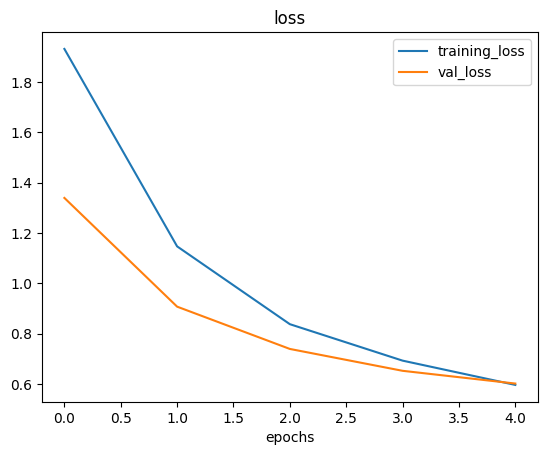

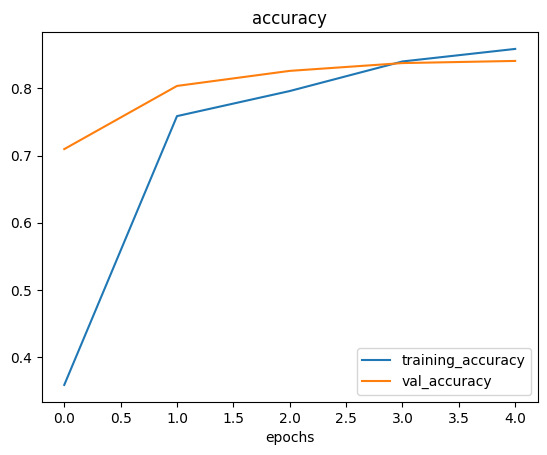

In [9]:
plot_loss_curves(model_0_history)

## Getting a feature vector from trained model

In [10]:
input_shape =(1,4,4,3)


# Create a random tensor
tf.random.set_seed(42)
input_tensor=tf.random.normal(input_shape)

print(f"Random input tensor:\n{input_tensor}\n")


# Pass the random tensor to Global average pooling 2D layer

global_average_pooled_tensor=tf.keras.layers.GlobalAveragePooling2D()(input_tensor)

print(f"2D average pooled random tensor:\n{global_average_pooled_tensor}\n")

global_average_pooled_tensor.shape

Random input tensor:
[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D average pooled random tensor:
[[-0.09368646 -0.45840448 -0.2885598 ]]



TensorShape([1, 3])

## Running a series of transfer learning experiments

In [11]:
# wget.download("https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip")

# zip_ref=zipfile.ZipFile("10_food_classes_1_percent.zip")
# zip_ref.extractall()
# zip_ref.close()

In [12]:
train_dir_1_per="10_food_classes_1_percent/train/"
test_dir="10_food_classes_1_percent/test/"

In [13]:
# Setup data loaders

IMG_SIZE=(224,224)

train_data_1_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_per,
                             label_mode="categorical" ,
                             image_size=IMG_SIZE,
                             batch_size=BATCH_SIZE
                             )


test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                             label_mode="categorical" ,
                             image_size=IMG_SIZE,
                             batch_size=BATCH_SIZE
                             )

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model 

In [18]:
from tensorflow.keras.layers.experimental import preprocessing
# Create data aug

data_augmentation= tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    
],name="data_augmentation")

## Visualize our data aug layer

(-0.5, 558.5, 555.5, -0.5)

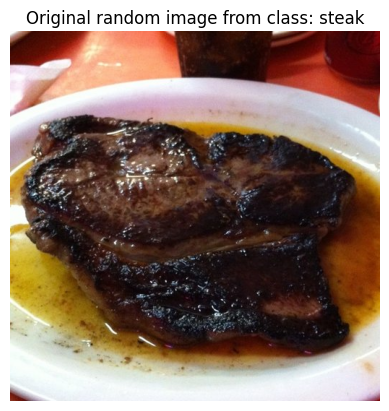

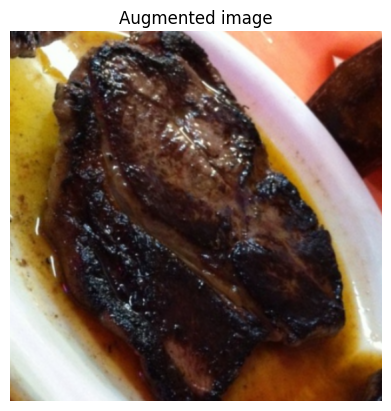

In [32]:
target_class=random.choice(train_data_1_percent.class_names)

target_dir="10_food_classes_1_percent/train/"+target_class 

random_image=random.choice(os.listdir(target_dir))

random_image_path=target_dir+"/"+random_image


# Read image 
img=mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False)


# Plot augmented random image

augmented_img=data_augmentation(img,training=True)
plt.figure()
plt.imshow(augmented_img/255.)
plt.title("Augmented image")
plt.axis(False)

### Model 1: Feature extraction transfer learning on 1 % of the data augmentation

In [33]:
# Create base model with tf.keras.applications

base_model=tf.keras.applications.EfficientNetB0(include_top=False)

# Freeze the base model =>underlying pre-trained patterns aren't updated

base_model.trainable=False

# Create inputs into our model

inputs=tf.keras.layers.Input(shape=(224,224,3),name="input_layer")

# Normalize in case of using (ResNet50v2)
# x=tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# Data augmentation layer
x= data_augmentation(inputs)


x=base_model(x)

# Average the outputs 

x=tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x)


# Create the output activation layer

outputs = tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)

# Combine inputs with outputs 

model_1 = tf.keras.Model(inputs,outputs)

In [34]:
model_1.compile(loss="categorical_crossentropy",
                     optimizer="Adam",
                     metrics=["accuracy"])

In [35]:
model_1_history=model_1.fit(train_data_1_percent,
                 epochs=5,
                 steps_per_epoch=len(train_data_1_percent),
        validation_data=test_data,
        validation_steps=0.25*len(test_data),
        callbacks=[
            create_tensorboard_callback(dir_name="transfer_learning",
                                        experiment_name="1_percent_data_aug")]
         )

Saving Tensorboard log files to: transfer_learning/1_percent_data_aug/20230319-144350
Epoch 1/5
3/3 [==============================] - 22s 6s/step - loss: 2.4343 - accuracy: 0.1000 - val_loss: 2.2034 - val_accuracy: 0.1953
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 2.2045 - accuracy: 0.1571 - val_loss: 2.1109 - val_accuracy: 0.2391
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 1.9632 - accuracy: 0.4429 - val_loss: 2.0058 - val_accuracy: 0.3234
Epoch 4/5
3/3 [==============================] - 5s 2s/step - loss: 1.9019 - accuracy: 0.5286 - val_loss: 1.9152 - val_accuracy: 0.3828
Epoch 5/5
3/3 [==============================] - 5s 2s/step - loss: 1.7153 - accuracy: 0.5714 - val_loss: 1.8410 - val_accuracy: 0.4313


In [36]:
results_1_percent_data_aug=model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 16s 194ms/step - loss: 1.8354 - accuracy: 0.4360


[1.835423469543457, 0.4359999895095825]

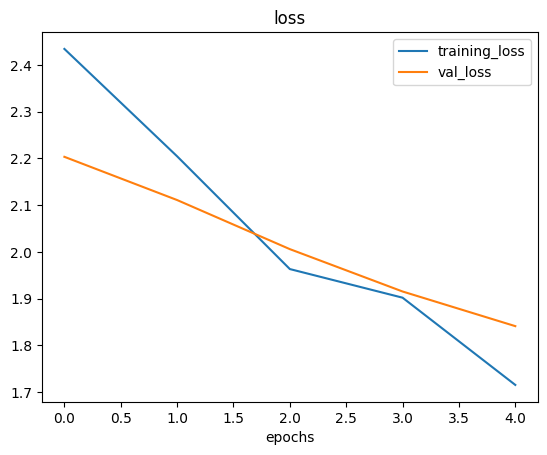

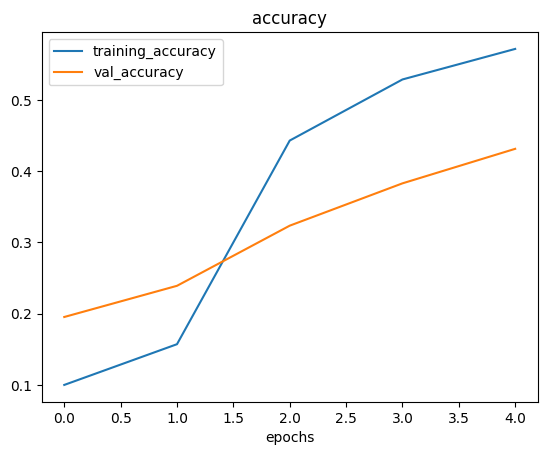

In [37]:
plot_loss_curves(history=model_1_history)

### Creating model checkpoint callback

In [44]:
# Set checkpoint path

checkpoint_path="ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's  weights

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
save_weights_only=True,
save_best_only=False,
save_freq="epoch", # Save every epoch,
verbose=1)


### Model 2: 10% data with augmentation

In [45]:
# Create base model with tf.keras.applications

base_model=tf.keras.applications.EfficientNetB0(include_top=False)

# Freeze the base model =>underlying pre-trained patterns aren't updated

base_model.trainable=False

# Create inputs into our model

inputs=tf.keras.layers.Input(shape=(224,224,3),name="input_layer")

# Normalize in case of using (ResNet50v2)
# x=tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# Data augmentation layer
x= data_augmentation(inputs)


x=base_model(x)

# Average the outputs 

x=tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x)


# Create the output activation layer

outputs = tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)

# Combine inputs with outputs 

model_2 = tf.keras.Model(inputs,outputs)

In [46]:
model_2.compile(loss="categorical_crossentropy",
                     optimizer="Adam",
                     metrics=["accuracy"])

In [47]:
model_2_history=model_2.fit(train_data_10_percent,
                 epochs=5,
                 steps_per_epoch=len(train_data_10_percent),
        validation_data=test_data,
        validation_steps=0.25*len(test_data),
        callbacks=[
            create_tensorboard_callback(dir_name="transfer_learning",
                                        experiment_name="10_percent_data_aug"),
            checkpoint_callback
            ],
        
         )

Saving Tensorboard log files to: transfer_learning/10_percent_data_aug/20230319-151713
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0072 - accuracy: 0.3413WARNING:tensorflow:Model was constructed with shape (None, 512, 3) for input KerasTensor(type_spec=TensorSpec(shape=(None, 512, 3), dtype=tf.uint8, name='random_flip_2_input'), name='random_flip_2_input', description="created by layer 'random_flip_2_input'"), but it was called on an input with incompatible shape (None, 224, 224, 3).

Epoch 1: saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 22s 587ms/step - loss: 2.0072 - accuracy: 0.3413 - val_loss: 1.5074 - val_accuracy: 0.6266
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3971 - accuracy: 0.6493
Epoch 2: saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 13s 535ms/step - loss: 1.3971 - accuracy: 0.6493 - val_loss: 

In [50]:
model_0.evaluate(test_data)

79/79 [==============================] - 12s 126ms/step - loss: 0.6011 - accuracy: 0.8408


[0.6011018753051758, 0.8407999873161316]

In [48]:
results_10_percent_data_aug=model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 9s 109ms/step - loss: 0.7185 - accuracy: 0.8088


[0.718467116355896, 0.8087999820709229]

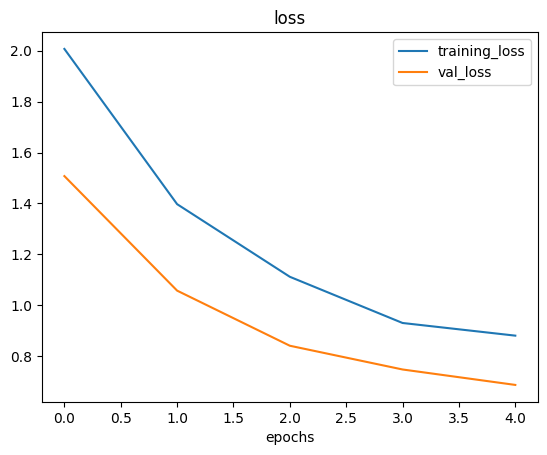

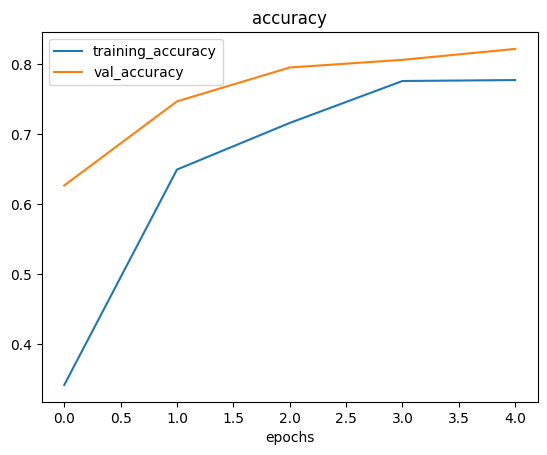

In [49]:
plot_loss_curves(history=model_2_history)

### Loading in checkpointed weights

In [51]:
# Load in saved model weights and evaluate model

model_2.load_weights(checkpoint_path)

In [52]:
# Evaluate model_2 with loaded weights 

loaded_weights_model_results=model_2.evaluate(test_data)

79/79 [==============================] - 10s 113ms/step - loss: 0.7185 - accuracy: 0.8088


In [54]:
results_10_percent_data_aug, loaded_weights_model_results

([0.718467116355896, 0.8087999820709229],
 [0.7184672951698303, 0.8087999820709229])

In [55]:
# Check to see if loaded model results are very close to our previous non-loaded model results

np.isclose(np.array(results_10_percent_data_aug),np.array(loaded_weights_model_results))

array([ True,  True])

## Model 3 : Fine-tuning an existing model on 10% of the data